# Ray Dalio's Holy Grail

### _Reducing return/risk ratio through diversification._

https://www.investopedia.com/video/play/ray-dalio-his-portfolio-holy-grail/

From _Principles: Life and Work_ by Ray Dalio.

> From my earlier failures, I knew that no matter how confident I was in making any one bet I could still be wrong—and that proper diversification was the key to reducing risks without reducing returns. If I could build a portfolio filled with high-quality return streams that were properly diversified (they zigged and zagged in ways that balanced each other out), I could offer clients an overall portfolio return much more consistent and reliable than what they could get elsewhere.”

In this notebook, we'll explore what Ray Dalio referrs to as the _Holy Grail of Investing_, how increasing diversification we are able to reduce overall risk, as measured by the standard deviation of portfolio returns.  
The idea is to show that, if we can find a basket of uncorrelated return streams (in practice we allow for low correlation), we can reduce the portfolio risk significantly by increasing the number of streams in our portfolio.

In [1]:
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import altair as alt

np.random.seed(42) # Set seed for reproducibility

We begin by creating a function that simulates `n` return streams with a given mean (`mean`) and standard deviation (`risk`), and a given average correlation (`corr`) between them.

In [2]:
def correlated_streams(n, mean, risk, corr):
    """Generates `n` return streams with given average `mean` and `risk`,
    and with an average correlation level `corr`.
    """
    num_samples = 10_000
    means = np.full(n, mean)
    
    corr_mat = np.full((n, n), corr, dtype=np.dtype("d"))
    np.fill_diagonal(corr_mat, 1,)
    cov_mat = corr_mat * risk**2
    
    streams = np.random.multivariate_normal(means, cov_mat, size=num_samples)
    
    return streams.T

Just to make sure, let's do a sanity check.

In [3]:
n = 5
mean, std, corr = 10, 15, 0.6

streams = correlated_streams(n, mean, std, corr)

In [4]:
streams.mean(axis=1)

array([10.12229747,  9.92797016,  9.98877207, 10.05103342,  9.90978558])

In [5]:
streams.std(axis=1)

array([15.07254044, 15.05168254, 15.17926238, 15.2192544 , 15.14908131])

In [6]:
np.corrcoef(streams)

array([[1.        , 0.60676484, 0.61222918, 0.61179636, 0.60301561],
       [0.60676484, 1.        , 0.61036834, 0.61049393, 0.61073826],
       [0.61222918, 0.61036834, 1.        , 0.61526424, 0.61265281],
       [0.61179636, 0.61049393, 0.61526424, 1.        , 0.605607  ],
       [0.60301561, 0.61073826, 0.61265281, 0.605607  , 1.        ]])

This is the simplest way to construct such a portfolio. We make each pariwise correlation between assets equal to a given level `corr`. The important point is that the average of all the pairwise correlations should be equal to `corr`.

We'll create a helper function to calculate the pooled risk of a given number of return streams in the porfolio.

In [7]:
def aggregate_risk(return_streams, n):
    """Returns the pooled risk (std) of the `n` first streams 
    in `return_streams`
    """
    assert len(return_streams) >= n
    
    aggregate_returns = np.sum(return_streams[:n], axis=0) / n
    return aggregate_returns.std()

Next, we'll build our simulated dataset. We'll analyse return streams with risk levels in the range 1% - 14%, for varying number of streams ranging from 1 to 20.  
We'll plot the risk levels for different average correlation, ranging from 0 to 0.7.

In [8]:
max_assets = 20
assets = range(1, max_assets+1)

mean = 10 # Avg mean return of 10%
risk_levels = range(1, 15)

index = pd.MultiIndex.from_product([risk_levels, assets], names=["risk_level", "num_assets"])
simulated_data = pd.DataFrame(index=index)

for risk in risk_levels:
    for corr in np.arange(0.0, .8, 0.1):
        return_streams = correlated_streams(max_assets, mean, risk, corr)
        risk_level = np.zeros(max_assets)
        for num_assets in assets:
            risk_level[num_assets-1] = aggregate_risk(return_streams, num_assets)
        simulated_data.loc[(risk, ), round(corr, 1)] = risk_level
        
simulated_data.columns.names = ["correlation"]

Let's have a look at our dataset.

In [9]:
simulated_data.query("risk_level == 14")

correlation                  0.0        0.1        0.2        0.3        0.4  \
risk_level num_assets                                                          
14         1           14.139732  14.183844  14.062874  13.906914  14.016018   
           2            9.971890  10.353876  10.942021  11.268121  11.719979   
           3            8.109977   8.858116   9.628288  10.189106  10.866995   
           4            6.986998   7.940064   9.000020   9.627738  10.427791   
           5            6.264615   7.383155   8.476107   9.258889  10.160074   
           6            5.716743   6.981279   8.180173   9.002885   9.964878   
           7            5.295934   6.662273   7.948934   8.810349   9.824147   
           8            4.947562   6.426823   7.746143   8.693509   9.722466   
           9            4.661358   6.241620   7.579661   8.579598   9.654701   
           10           4.442710   6.093881   7.460082   8.515337   9.593855   
           11           4.239165   5.985589   7.368723   8.447905   9.551672   
           12           4.067129   5.848384   7.261351   8.386694   9.511828   
           13           3.899028   5.742075   7.186550   8.324049   9.473521   
           14           3.748972   5.640994   7.124659   8.270063   9.439662   
           15           3.621510   5.578849   7.071261   8.237998   9.407296   
           16           3.504821   5.511867   7.032749   8.213322   9.375700   
           17           3.388423   5.448855   6.989579   8.190652   9.355400   
           18           3.286793   5.395965   6.953230   8.157502   9.333752   
           19           3.202366   5.352398   6.913921   8.141816   9.315900   
           20           3.127220   5.314700   6.896133   8.123222   9.304375   

correlation                  0.5        0.6        0.7  
risk_level num_assets                                   
14         1           13.967769  14.047985  14.124923  
           2           12.092035  12.523072  12.993926  
           3           11.527557  11.936896  12.700021  
           4           11.156455  11.632607  12.501330  
           5           10.940836  11.467615  12.354408  
           6           10.783878  11.360462  12.244618  
           7           10.681967  11.263729  12.185342  
           8           10.583549  11.178877  12.154764  
           9           10.529631  11.145755  12.109616  
           10          10.488526  11.119618  12.103459  
           11          10.444280  11.096220  12.079866  
           12          10.406193  11.076911  12.068993  
           13          10.369270  11.052183  12.053648  
           14          10.344146  11.026962  12.032337  
           15          10.329517  11.021145  12.023096  
           16          10.311569  11.012383  12.013513  
           17          10.295327  11.004884  12.003186  
           18          10.279044  10.988993  12.000082  
           19          10.256781  10.980980  11.996158  
           20          10.239964  10.973629  11.985602

We can already see how portfolio risk _decreases_ as we add more assets, with sharper declines when we they have low correlation.

To recreate Dalio's chart (as seen in [this video](https://www.investopedia.com/video/play/ray-dalio-his-portfolio-holy-grail/)), we create a function that produces a plot given our simulated data and a risk level.

In [10]:
def plot_risk_level(data, risk_level):
    subset = data.query("risk_level == @risk_level")
    stacked = subset.stack().reset_index(name="risk")
    stacked.head()
    
    chart = alt.Chart(data=stacked)

    highlight = alt.selection(type="single", on="mouseover",
                              fields=["correlation"], nearest=True)

    base = chart.encode(
                alt.X("num_assets", axis=alt.Axis(title="Number of Assets")),
                alt.Y("risk", axis=alt.Axis(title="Risk %")),
                alt.Color("correlation:N", scale=alt.Scale(scheme="set2")))

    points = base.mark_circle().encode(
        opacity=alt.value(0)
    ).add_selection(
        highlight
    ).properties(
        height=400,
        width=600,
        title="Risk % by number of assets in portfolio"
    )

    lines = base.mark_line().encode(
        size=alt.condition(~highlight, alt.value(1), alt.value(3)),
        tooltip=["correlation"]
    )

    return points + lines

Let's see how diversification benefits a portfolio with assets that have a risk level of 10%.

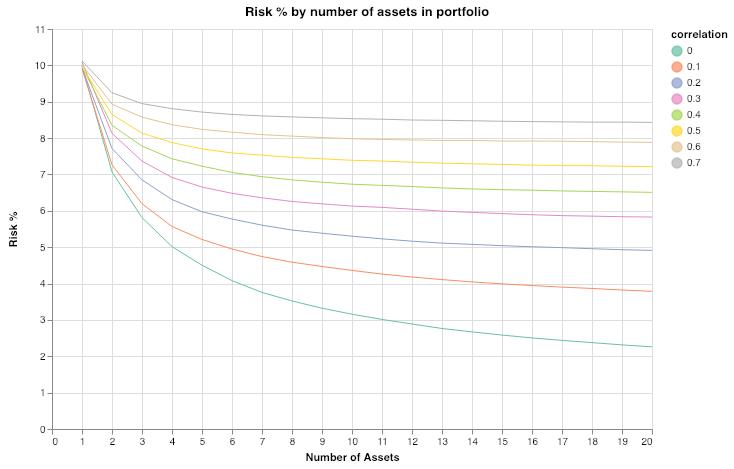

In [11]:
plot_risk_level(simulated_data, 10)

A highly correlated portfolio _does not_ benefit much from increased diversification. We get diminishing returns by adding highly correlated assets beyond 3 or 4.  
In contrast, we can _halve_ the risk by adding just 6 or 7 uncorrelated (or more realistically, weakly correlated) assets to a portfolio.

Let's plot the risk levels for a portfolio with returns streams with 7% risk.

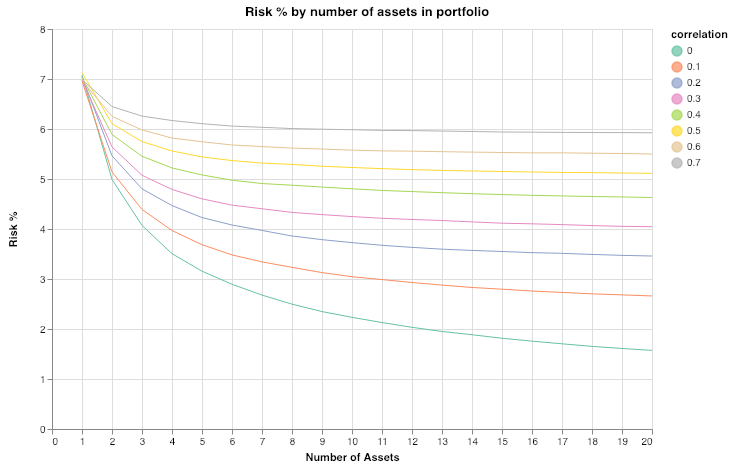

In [12]:
plot_risk_level(simulated_data, 7)

## Conclusion

The benefits of diversification are generally well known: reduced risk through exposure to different sources of income.  
The insight Dalio brings to the forefront, is that the construction of a diversified portfolio through a combination of _uncorrelated_ return streams, significantly decreases our overall risk, raising in turn our return / risk ratio. By the careful mixing of uncorrelated assets, we capture true _alpha_, enabling us to use leverage to increase our returns.